# Capstone Project 

Twitter sentiment anaylsis to predict twitter sentiment analysis

# Obtain 

In [1]:
import numpy as np
import pandas as pd
import re 
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords
stopword_list = stopwords.words('english')
import matplotlib.pyplot as mlpt
import tweepy
import sys
sys.path.append("twint/")
!pip install --user -r requirements.txt
!pip install --upgrade --user -e git+https://github.com/twintproject/twint.git@origin/master#egg=twint
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("twint/")
import twint 
import nest_asyncio
import warnings
warnings.filterwarnings('ignore')
nest_asyncio.apply()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/afeinberg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
You should consider upgrading via the '/Users/afeinberg/anaconda3/envs/learn-env/bin/python -m pip install --upgrade pip' command.
Obtaining twint from git+https://github.com/twintproject/twint.git@origin/master#egg=twint
ERROR: Exception:
Traceback (most recent call last):
  File "/Users/afeinberg/anaconda3/envs/learn-env/lib/python3.6/site-packages/pip/_internal/vcs/git.py", line 293, in get_remote_url
    found_remote = remotes[0]
IndexError: list index out of range

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/afeinberg/anaconda3/envs/learn-env/lib/python3.6/site-packages/pip/_internal/cli/base_command.py", line 188, in _main
    status = self.run(options, args)
  File "/Users/afeinberg/anaconda3/envs/learn-env/lib/python3.6/site-packages/pip/_internal/cli/req_command.py", line 185, in wrapper
    return func(self

### Using Twint for Twitter

Twint utilizes Twitter’s search operators to let you scrape Tweets from specific users, and scrape Tweets relating to certain topics. It is the route we need to take as it allows you to pull a large volume of tweets and can access more outdated tweets. This will be helpful in building a predictive time series consisting of 30 days of tweets. 

In [3]:
c = twint.Config()
c.Search = 'Apple', 'aapl'
c.Since = '2019-01-01'
c.Until = '2019-02-28'
c.Limit = 1000
c.Store_csv = True
c.Pandas = True
c.Replies = True
c.Lang = 'en'
c.Count = True
c.Format = "Tweet id: {id} | Date: {date} | Time: {time} | Tweet: {tweet} | Replies: {replies}"
c.Custom['tweet'] = ['id', 'date', 'time', 'tweet','replies']
twint.run.Search(c) 

Tweet id: 1100848143451807745 | Date: 2019-02-27 | Time: 15:00:24 | Tweet: Official iOS 12 adoption stats as published by Apple through February 24, 2019. $AAPL #Peerless pic.twitter.com/uF9f4SeS8y | Replies: 1
Tweet id: 1100756422541766657 | Date: 2019-02-27 | Time: 08:55:56 | Tweet: Haha your not very informed it’s RIP $AAPL not $QCOM based on that trend you presented. #Qualcomm revenue will rise off this bottom with their chips, and modems fueling the Chinese OEMs recent growth into global markets. #APPLE isn’t a customer anymore using inferior $intc. | Replies: 1
Tweet id: 1100745238316965888 | Date: 2019-02-27 | Time: 08:11:30 | Tweet: @FTC with #Huawei & #Apple as a star witness wants Judge Koh to free 6 billion Non-Americans from paying royalties for American 5G Innovation. Suits Huawei just fine don’t have China government stabbing them in the back! #qualcomm $qcom @POTUS @DOJPH #ftcqcom $mu $ge $aapl $intc https://twitter.com/newtgingrich/status/1100733935162716160 … | Replies

Tweet id: 1098598266583900163 | Date: 2019-02-21 | Time: 10:00:12 | Tweet: Two-years-ahead-of-Apple, Folding-OLED  Love-that-phone, will-never-have-to-carry-a-laptop-again-if-it-works as-advertised  Game-changer  #Samsung $AMAT $AAPL | Replies: 11
Tweet id: 1098594317990531076 | Date: 2019-02-21 | Time: 09:44:30 | Tweet: You contradict yourself #Qualcomm SEP royalty (3.25% X $400 capped ASP)  compared against- #Apple 30% charge to AP developers for use of AAPL’s iTunes platformNo Cap? + AAPL’s iTunes monthly subscriber charge of XXXXX | Replies: 0
Tweet id: 1098494361724059649 | Date: 2019-02-21 | Time: 03:07:19 | Tweet: $AAPL: yes?  pic.twitter.com/u1Rhlsy0k0 | Replies: 1
Tweet id: 1098435074045956096 | Date: 2019-02-20 | Time: 23:11:44 | Tweet: @AppleInc_AAPL an email received confirming transaction processed vide no P23166782093 for $100 which did not do. Trying to connect apple but not able to. Pls look into the matter and confirm if the same is fake email or id been miss used. | R

Tweet id: 1097362129643016192 | Date: 2019-02-18 | Time: 00:08:14 | Tweet: $AAPL; 12/03/2018 – Apple to Acquire Magazine-Subscription Service Texture; 07/04/2018 – HomePod has Siri inside, but will only play music from Apple Music; 25/04/2018 – TRUMP SAYS WILL TALK ABOUT TRADE WITH APPLE INC AAPL.O CEO COOK AT WHITE HOUSE TODAY -TWEET; $AAPL | Replies: 1
Tweet id: 1097362127919239173 | Date: 2019-02-18 | Time: 00:08:13 | Tweet: the recycling robot; 14/05/2018 – TIAA-CREF Adds Aptiv, Exits Baidu, Cuts Apple: 13F; 28/03/2018 – U.S. Cellular to Offer New 9.7-inch iPad With Apple Pencil Support; 09/04/2018 – AAPL: Apple announces red iPhone 8 and iPhone 8 Plus, coming April 13th. – ! $AAPL | Replies: 1
Tweet id: 1097362126216269824 | Date: 2019-02-18 | Time: 00:08:13 | Tweet: About 24.63 million shares traded. Apple Inc. (NASDAQ:AAPL) has risen 0.17% since February 17, 2018 and is uptrending. It has outperformed by 0.17% the S&P500. Some Historical AAPL News: 19/04/2018 – Apple celebrates 

Tweet id: 1096921256786415616 | Date: 2019-02-16 | Time: 18:56:22 | Tweet: But #nokia had #apple and #samsung as competitor, but who else is strong enough to fight #aapl except #huwaii that us banned already | Replies: 0
Tweet id: 1096818105869754369 | Date: 2019-02-16 | Time: 12:06:28 | Tweet: /2 And here's $AAPL, just for giggles.  Absolutely nothing -- I mean *nothing* -- looks good in this market to me.  Positions: short Apple, short $QQQ, short $DIA, short $SPY. pic.twitter.com/KdO9AxvYyM | Replies: 1
Tweet id: 1096780862924836865 | Date: 2019-02-16 | Time: 09:38:29 | Tweet: Perhaps better news story for past week regarding blockchain & Apple.   Happy to also hear WB trim $aapl position recently too. This new story is disgusting.  Long $btc short everything associated with banks/fraud. | Replies: 0
Tweet id: 1096777727091331073 | Date: 2019-02-16 | Time: 09:26:01 | Tweet: It’s for financial Twitter. Stock tickers after the $ like $cbs $aapl $tsla $msft CBS Apple Tesla Microsoft if

Tweet id: 1094842872564772864 | Date: 2019-02-11 | Time: 01:17:36 | Tweet: More interesting news about Apple Inc. (NASDAQ:AAPL) were released by:  http://Seekingalpha.com  and their article: “Why Apple Won’t Be The Next BlackBerry – Seeking Alpha” published on January 11, 2019 as well as  http://Seekingalpha.com ‘s news article titled: “Apple Earnings: | Replies: 1
Tweet id: 1094842870744403968 | Date: 2019-02-11 | Time: 01:17:36 | Tweet: Pre-Market Most Active for Jan 30, 2019 : VALE, SID, AMD, T, BABA, AAPL, PHG, FHB, ABB, SQQQ, ACIU, QQQ – Nasdaq” published on January 30, 2019,  http://Seekingalpha.com  published: “Apple: Valuation Vs. Sentiment – Seeking Alpha” on January 11, 2019. | Replies: 1
Tweet id: 1094842340928311296 | Date: 2019-02-11 | Time: 01:15:29 | Tweet: Synovus Financial Corp reported 372,369 shares. Edmp reported 8.49% in Apple Inc. (NASDAQ:AAPL). Cadence Capital Management Limited Com holds 0.18% or 14,402 shares. | Replies: 0
Tweet id: 1094842339342905344 | Date: 

Tweet id: 1093139415940169728 | Date: 2019-02-06 | Time: 08:28:40 | Tweet: Netflix ($NFLX) closed at $351.34 a reaction to the JPMorgan suggestion that Apple ($aapl)could purchase them as well as Activision Blizzard ($ATVI). | Replies: 1
Tweet id: 1093116936861483009 | Date: 2019-02-06 | Time: 06:59:21 | Tweet: AAPL is a single platform company.  They aren’t going but an epic and have to support Windows Android Non-Safari browsers, etc…   Apple has been historically awful in this space.  And no healthcare org will buy into a iOS / MacOS only solution. | Replies: 0
Tweet id: 1093023749874409472 | Date: 2019-02-06 | Time: 00:49:04 | Tweet: @Apple profit looking maxed. Only dollar pool large enough to move the dial is global subscription TV. @Disney rolling up their rights to launch streaming and @RobertIger needs an exit...maybe time for @Tim_Cook and #AAPL to “reach a net cash neutral position” and buy #DIS | Replies: 0
Tweet id: 1092958346733178881 | Date: 2019-02-05 | Time: 20:29:10 |

Tweet id: 1091105203942772738 | Date: 2019-01-31 | Time: 17:45:27 | Tweet: only thing is that they are in diff sectors and while amzn is firing on all cylinders and more, apple needs to research a new direction with dwindling iphone sales.  perhaps aapl needs to buy something to jumpstart.  amzn is a like a mutual fund, on roids. | Replies: 0
Tweet id: 1091100717933154304 | Date: 2019-01-31 | Time: 17:27:37 | Tweet: Amazon sales growth in holiday quarter: +19.7% Apple: -4.5%  $AMZN profit growth in holiday quarter: +63.4% $AAPL: -0.5%. Stocks trade on forward prospects and Wall ST. likes the consumer friendly business over the (declining) premium margin play of AAPL. | Replies: 0
Tweet id: 1091075221824593921 | Date: 2019-01-31 | Time: 15:46:18 | Tweet: #Apple said iPhone Worldwide Active #SmartPhones Users were 0.9B, >1/3 of the 2018’s 2.53B Total, per @StatistaCharts. Apple sold 209M—15% Market Share, in a market down 4.1% to 1,405M units. Great news for $AAPL shareholders! Apple hol

Tweet id: 1090614529388613632 | Date: 2019-01-30 | Time: 09:15:41 | Tweet: Apple bans Facebook research app that collects users' information, Recode says  $AAPL @theflynews @Recode | Replies: 0
Tweet id: 1090603610004770821 | Date: 2019-01-30 | Time: 08:32:17 | Tweet: Apple's challenges in China will persist, says Wells Fargo  $AAPL | Replies: 1
Tweet id: 1090598542354333701 | Date: 2019-01-30 | Time: 08:12:09 | Tweet: Apple outlook not worse than expected, not particularly good, says KeyBanc $AAPL | Replies: 1
Tweet id: 1090572268965634049 | Date: 2019-01-30 | Time: 06:27:45 | Tweet: @GDPRReport This is not the first time that Apple did not report a breach. Is Aple too big to report? $AAPL $MSFT $GOOGL $AMZN $IBM $ORCL $CRM $TSLA $SNAP $FB @WSJ @business @Reuters @BGR @BlackBerry @CNBC | Replies: 0
Tweet id: 1090571546056364032 | Date: 2019-01-30 | Time: 06:24:53 | Tweet: Lol 😂. Majority of people around the world want an Apple iPhone and/or Apple products, they just have to be able t

Tweet id: 1090425147683614720 | Date: 2019-01-29 | Time: 20:43:08 | Tweet: Is he on via $AAPL iPhone FaceTime?  ⚠️ WARNING — Dear #iPhone Users, Turn OFF "FaceTime" App Immediately.  A New Apple #FaceTime Privacy Bug Lets Callers Hear and See You Even If You Don't Accept the Call. (It's Unpatched)   https://thehackernews.com/2019/01/apple-?m=1 … | Replies: 0
Tweet id: 1090424578680057857 | Date: 2019-01-29 | Time: 20:40:53 | Tweet: Apple banned Facebook’s VPN app: Onavo last year, now we are waiting to hear if Apple will revoke Facebook’s internal use only enterprise certificate for sidestepping the App Store, this could heat up Zuck vs. Cook tensions $FB $AAPL | Replies: 1
Tweet id: 1090424069491707904 | Date: 2019-01-29 | Time: 20:38:51 | Tweet: So basically @Apple $AAPL couldn't even beat already lowered earnings which ironically it lowered itself! | Replies: 1
Tweet id: 1090410222122864640 | Date: 2019-01-29 | Time: 19:43:50 | Tweet: "Can" is different from "should". Why buy Tesla 

Tweet id: 1090184706530787330 | Date: 2019-01-29 | Time: 04:47:43 | Tweet: @AppleSupport $AAPL Can Apple create a sloth emoji? It could really help many users like me with self-expression or be used to accurately describe DMV wait times. | Replies: 0
Tweet id: 1090135284505894912 | Date: 2019-01-29 | Time: 01:31:20 | Tweet: #Apple's #Earnings : preview $aapl  >    https://www.marketwatch.com/story/apple-earnings-where-does-apple-go-from-here-2019-01-25 … | Replies: 1
Tweet id: 1090106646250975234 | Date: 2019-01-28 | Time: 23:37:32 | Tweet: The $AAPL fans asked for new features and I guess Apple delivered. #Innovation | Replies: 0
Tweet id: 1090062271479406592 | Date: 2019-01-28 | Time: 20:41:12 | Tweet: What if Apple, Microsoft code IS the malware???. #installGentoo we may need a Linux free libre software phone. Yet sabotaged by aapl Goog incompetence | Replies: 0
Tweet id: 1090004408430223363 | Date: 2019-01-28 | Time: 16:51:16 | Tweet: I think tomorrow with $aapl guide is key for $L

Tweet id: 1088582822212845568 | Date: 2019-01-24 | Time: 18:42:24 | Tweet: Isn't it interesting how moats can be under threat? This is exactly same issue with apple. Their products are so good ( disclosure - shareholder and pdt owner) that there is no desire to replace them. on 2010 iMac and macbook pro. 2011 ipad, and mini.  A big challenge for $AAPL | Replies: 0
Tweet id: 1088558093515063297 | Date: 2019-01-24 | Time: 17:04:08 | Tweet: Been thinking about longer refresh cycles lately.  Most people I know putting off upgrading $AAPL phones... why?  Price.  Apple has completely maxed out price and it’s really elongating the cycle now. | Replies: 1
Tweet id: 1088512976104185856 | Date: 2019-01-24 | Time: 14:04:51 | Tweet: Hate Apple or $AAPL? | Replies: 0
Tweet id: 1088472981666521088 | Date: 2019-01-24 | Time: 11:25:56 | Tweet: $AAPL Daily: #AAPL did not even make it to 160. Back below BC with 13MA rolling over.  If 13MA crosses BC bearish, would be extremely bad for the Darling of the

Tweet id: 1087761282047111173 | Date: 2019-01-22 | Time: 12:17:53 | Tweet: Don’t forget about headphones with no wires-truly amazing inside the paper bag thinking. FYI-I own mucho AAPL stock and at least 18 Apple products. I have kids-we love Apple -just think the “black turtle neck” genius is sadly gone from the company ethos. Waiting on red ear buds | Replies: 0
Tweet id: 1087759934563987456 | Date: 2019-01-22 | Time: 12:12:32 | Tweet: Totally agree with you on $AAPL and innovation (the definition of which most people don’t understand anyway), but healthcare is also low hanging fruit. Apple is into advanced R&D on at least 8 or 10 other transformative fronts. | Replies: 0
Tweet id: 1087748701802713088 | Date: 2019-01-22 | Time: 11:27:54 | Tweet: Apple an innovator? I think you may be stuck in the late 2000s when the first iPhones were coming out! Many words to describe $AAPL these days and I would not list “innovator” as one of them. | Replies: 2
Tweet id: 1087744899196297216 | Date:

Tweet id: 1086299078257004544 | Date: 2019-01-18 | Time: 11:27:37 | Tweet: @tim_cook since $aapl seems to be the only prominent tech company taking user privacy serious, do you see an Apple ID-based single sign on system being offered as an alternative to Facebook and Google single sign on? #dataprivacy | Replies: 0
Tweet id: 1086242296000065536 | Date: 2019-01-18 | Time: 07:41:59 | Tweet: @twelvesouth Journal for @apple iPhone XS & XS Max; (N30,600) $84 @aapltrdng  SERVES;— GENUINE LEATHER  WALLET  CARDS & ID HOLDER   & ULTRA HARDSHELL SECURE iPHONE POUCH — #aapl #aapltrdng #apple #twelvesouth #iphonexs #journal #leatherwalletcase #cardholder #winter #Wintersales pic.twitter.com/c69bO3Wqn2 | Replies: 0
Tweet id: 1086241750493073409 | Date: 2019-01-18 | Time: 07:39:49 | Tweet: @twelvesouth Journal for @apple iPhone XS & XS Max; (N30,600) $84 @aapltrdng  SERVES;— GENUINE LEATHER  WALLET  CARDS & ID HOLDER   & ULTRA HARDSHELL SECURE iPHONE POUCH — #aapl #aapltrdng #apple #twelvesouth #ip

Tweet id: 1085500034895003649 | Date: 2019-01-16 | Time: 06:32:30 | Tweet: Yes I know. You made all that money by that $2 stock price increase yesterday. Play the long game Apple, play the long game. Buy a sexy company that needs cash and needs help. Throw in and lead a change. Form a sexy partnership with a great company that needs help. $AAPL | Replies: 0
Tweet id: 1085448165745197057 | Date: 2019-01-16 | Time: 03:06:24 | Tweet: Oh, and AAPL @Apple is particularly and expressly prohibited from even reading that footnote on account of I actually wouldn’t put it past the current, rotten Apple to try something of the sort but not nearly clever enough to have come up with it on their own. Tim Cook Φ lizard.  https://twitter.com/ethicalsmut/status/1085446847878098946 … | Replies: 0
Tweet id: 1085372013026443264 | Date: 2019-01-15 | Time: 22:03:47 | Tweet: Great work AAPL is doing too with DXCM for glucose monitoring.  Great interview last week with CEO Kevin Sayer!  As TC said, he thinks 

Tweet id: 1083784772466413568 | Date: 2019-01-11 | Time: 12:56:40 | Tweet: Hey @BrianFeroldi, it was you and @dannyvena who turned me on to $BL!   Re: $SWKS I like to say, "Every time Apple $AAPL sneezes, Skyworks is diagnosed with the flu." But I think that some nice long-term catalysts will soon be in play too. #IoT #5G https://www.fool.com/investing/2018/12/26/near-a-3-year-low-is-skyworks-solutions-a-buy.aspx … | Replies: 1
Tweet id: 1083767220155699200 | Date: 2019-01-11 | Time: 11:46:55 | Tweet: Wouldn’t DIG be the ticker ? Is it aapl or Apple ? Just saying 👍 | Replies: 0
Tweet id: 1083761489742348288 | Date: 2019-01-11 | Time: 11:24:09 | Tweet: $AAPL Daily: #AAPL forming red inverted hammer right at 13MA bearish backtest. Historically this is a very bearish setup & could rechase lower yellow bear channel support quickly, just FYI, manage risk in case...  #APPLE #Tech #Technology pic.twitter.com/sJcBkbMlND | Replies: 3
Tweet id: 1083741669177012224 | Date: 2019-01-11 | Time: 10:0

Tweet id: 1082961529547321345 | Date: 2019-01-09 | Time: 06:25:23 | Tweet: If premarket $AAPL any indication, market is perhaps finally wising up to the fact Nikkei @NAR has a very poor track record of Apple coverage, in particular when it comes to supply chain. Also, their timing citing “sources’ has always been…suspect. Total short hack shop. | Replies: 0
Tweet id: 1082939804642361344 | Date: 2019-01-09 | Time: 04:59:04 | Tweet: #FUTR+5% £5.12✅ #FUTURE coverage of #CES2019 @techradar #Apple just had its best CES, & it's not even at the show  https://buff.ly/2FkhraX  $AAPL @Intel announces its first 10nm Ice Lake #processors  https://buff.ly/2FgsSAk  $INTC #TECH #AI #ML #VR #IoT #BigData #ROBOTICS #DL pic.twitter.com/Sd0GYJGQgH | Replies: 1
Tweet id: 1082938792007397376 | Date: 2019-01-09 | Time: 04:55:02 | Tweet: Hey @jimcramer @MadMoneyOnCNBC  Guess that great interview with Tim Cook in Cupertino yesterday wasn't the "I do my homework" kind, eh?  Being too much of a lapdog for Cook 

Tweet id: 1082641210001539072 | Date: 2019-01-08 | Time: 09:12:33 | Tweet: 20 years after that we will exist as a single hive mind powered by AWS, running on Apple hardware, finally proving that $AAPL is, in fact, a device company and not a services company. | Replies: 0
Tweet id: 1082588623382421505 | Date: 2019-01-08 | Time: 05:43:35 | Tweet: Another big user base for Apple... $AAPL | Replies: 0
Tweet id: 1082464643187015680 | Date: 2019-01-07 | Time: 21:30:56 | Tweet: Apple canceled portion of iPhone XR orders that were delayed to this quarter from last year - Economic Daily News. Taiwan’s Pegatron is main assembler for iPhone XR. Other suppliers include GIS and TP AAPL NDX (-/v), Taiex (-), Kospi EWY (=/-) | Replies: 0
Tweet id: 1082453355929100294 | Date: 2019-01-07 | Time: 20:46:05 | Tweet: Apple Daily Put/Call & Put/Call Open Interest Ratio. Always ambiguous whether investors establishing initial bullish position or selling covered calls near price bottoms. Nevertheless, worth c

Tweet id: 1081698229832613890 | Date: 2019-01-05 | Time: 18:45:29 | Tweet: Problem is that there's no proof about the Huawei thing and might be a political hostage thing. Also Apple lost their innovative ability when Steve Jobs passed on. Feels like most of $AAPL research is towards marketing more than innovation. | Replies: 0
Tweet id: 1081694979049906178 | Date: 2019-01-05 | Time: 18:32:34 | Tweet: $aapl held up well in October’s sell off. Look at the chart. It was not until Apple’s quarter report, in early Nov, where they said they wouldn’t give iPhone numbers anymore, when the stock really got hit. The Chaikin System was warning even before this event happened. | Replies: 0
Tweet id: 1081628184460840960 | Date: 2019-01-05 | Time: 14:07:09 | Tweet: My point wasn't that Apple was the entirety of consensus halving...  point was that consensus halving *includes* Apple's revision...  (or am I mistaken and it hasn't incorporated AAPL yet...?)  https://twitter.com/TrinityAssetMan/status/1

Tweet id: 1081170727926222848 | Date: 2019-01-04 | Time: 07:49:23 | Tweet: Heading into this week, Wall St's 12 month price target on Apple $AAPL was nearly $70 above its closing price. The dreaded crowded trade strikes again.  Via @BearTrapsReport pic.twitter.com/GLLqRGKo64 | Replies: 2
Tweet id: 1081148422378287106 | Date: 2019-01-04 | Time: 06:20:45 | Tweet: Yeah, stock markets are always about future growth and understand why there’s pessimism about AAPL. I’m still impressed with Apple’s ability to pull in a Billion dollars a day! | Replies: 0
Tweet id: 1081142604992004096 | Date: 2019-01-04 | Time: 05:57:38 | Tweet: Apple happened and dragged everyone down (see aapl) | Replies: 1
Tweet id: 1081112280257855488 | Date: 2019-01-04 | Time: 03:57:08 | Tweet: You're a genius. Buy as much Apple as you can afford. Then go and buy as much Tesla stock as you can afford. Next step: wait about 5-10 years to see all time high again. Brilliant strategy. Mean time, start a YouTube channel to pum

Tweet id: 1080940785095331841 | Date: 2019-01-03 | Time: 16:35:40 | Tweet: Apple is now (40%) off its all time high.   $AAPL | Replies: 0
Tweet id: 1080939591455203328 | Date: 2019-01-03 | Time: 16:30:56 | Tweet: @apple @applenews Fuck, I never knew I was SO influential, today I switched from Apple(iPhone7+) to OnePlus(6T), & Apple shares fell almost 10%, losing ~ $75bn in one day. AAPL has lost $440bn in the last 3 months coz Cook & Co is charging TOO MUCH for iPhones. Yeah, I said it! | Replies: 0
Tweet id: 1080937642483695616 | Date: 2019-01-03 | Time: 16:23:11 | Tweet: @Apple stock today ended $0.19 above 52 week low of $142.00, also set today.  And $AAPL in 2018 bought back BILLION$ in their stock at prices that were ALL higher than today.  Hey @T_Cook what do you have to lose???  #taxscam. “They’ll invest it in growing their business...” | Replies: 0
Tweet id: 1080936641064128512 | Date: 2019-01-03 | Time: 16:19:12 | Tweet: Judging by the comments, I see Apple is impressing every

Tweet id: 1080869330454278144 | Date: 2019-01-03 | Time: 11:51:44 | Tweet: And Apple is apparently buying back its stock starting at $142 in an attempt to maintain price above $145 ish. Wait a couple hours and AAPL will be back down again. They can’t empty their coffers all in one day. | Replies: 0
Tweet id: 1080867550433546240 | Date: 2019-01-03 | Time: 11:44:40 | Tweet: very little... $nke and $aapl are both fad companies. They are both selling commodities and are only as good as customers perceive them to be. While people will pay up to some degree for a fad there are limits as Apple is finding out. | Replies: 1
Tweet id: 1080866077377261568 | Date: 2019-01-03 | Time: 11:38:49 | Tweet: At least rotten apple 🍎 s don’t smell as bad as rotten taters lol!! $AAPL 😝🥔 | Replies: 0
Tweet id: 1080865833205739520 | Date: 2019-01-03 | Time: 11:37:50 | Tweet: #China slow down and fewer #iPhone upgrades in developed markets for $AAPL #Apple. BUT - the company's also been ceding market share in C

Tweet id: 1080832224898048000 | Date: 2019-01-03 | Time: 09:24:17 | Tweet: Official iOS 12 adoption stats as published by Apple through January 1, 2019. [It's not Nokia.] $AAPL  pic.twitter.com/2eDism9bho | Replies: 1
Tweet id: 1080831120802021379 | Date: 2019-01-03 | Time: 09:19:54 | Tweet: Cook also mentioned that people are not upgrading as much as expected, which speaks to a much more serious problem -- new iPhone design/features are failing to attract consumers. #Apple #iPhone $AAPL | Replies: 0
Tweet id: 1080828185737134080 | Date: 2019-01-03 | Time: 09:08:14 | Tweet: @cvpayne Charles - Re $AAPL  this looks more like an Apple specific issue that they believed people including China & India would pay $1000+ for a Google, Snapchat, YouTube, Twitter delivery device. Product strategy all wrong | Replies: 0
Tweet id: 1080827848653447168 | Date: 2019-01-03 | Time: 09:06:54 | Tweet: Apple shares tumble after-hours as the iPhone maker cuts its sales forecast, citing weak China sales amid

Tweet id: 1080694888247640064 | Date: 2019-01-03 | Time: 00:18:34 | Tweet: In a saturated market and with slower upgrade cycles, Apple’s strategy has been to grow profits via share gains + higher ASPs. If you think they lied, you weren’t paying attention. $AAPL Strat is transparent, but it doesn’t work in this economy and with minor YOY iPhone upgrades. | Replies: 0
Tweet id: 1080677006642163713 | Date: 2019-01-02 | Time: 23:07:31 | Tweet: I agree, but I think they are aware & will respond. We’ll just have to wait and see. I think the stock market is overreacting. You own an Apple made product that spans 5 different categories and I know you’re not an AAPL fanboy. That’s impressive. | Replies: 0
Tweet id: 1080676981845442561 | Date: 2019-01-02 | Time: 23:07:25 | Tweet: When Tim Cook took Apple to $1 trillion MC, WS praised his success.   When Q1 guidance cut, WS wants him out for lack of innovation.   Just to show you how brutal people can be when dealing with money. $AAPL | Replies: 1

Tweet id: 1080620721498279936 | Date: 2019-01-02 | Time: 19:23:51 | Tweet: Geeez Josh, $84,000,000,000 in the quarter for Apple is something your pissed about??? I’ll keep my #AAPL and will continue to add to it the next 6 month. Thanks 🤔😊🇺🇸 @CNBCFastMoney @SquawkCNBC @CNBC @petenajarian | Replies: 0
Tweet id: 1080618174457040897 | Date: 2019-01-02 | Time: 19:13:44 | Tweet: Apple organic demand is not slowing (excluding macroeconomic issues).The bigger you get the harder it is to keep up with growth %, nonetheless your re still growing.   Big $$$ uses apple products.   AAPL seems to be more focused on growing the services (iCloud, Apple Music, etc) | Replies: 0
Tweet id: 1080617040187088897 | Date: 2019-01-02 | Time: 19:09:13 | Tweet: @Apple @tim_cook gave many excuses for why #iPhone sales will be weaker than expected except for the biggest one: they’ve become too damned expensive. $AAPL | Replies: 0
Tweet id: 1080616468146839552 | Date: 2019-01-02 | Time: 19:06:57 | Tweet: Good point

Tweet id: 1080592429538074625 | Date: 2019-01-02 | Time: 17:31:26 | Tweet: many of my diehard friends of apple producta , bought Leneo laptops beside that aapl is manufacturing new iphones in india which used to account for 10% of sale. apple will loose all the margins. so i think appl will show earning slow down in few quarters, skeptic of 145 level | Replies: 0
Tweet id: 1080592342657175552 | Date: 2019-01-02 | Time: 17:31:05 | Tweet: #Cook said the variety of @apple products & their price spread, made raw phone sales less meaningful than the expanded data $Aapl offers in other areas.  https://twitter.com/zapher134/status/1080589337836904450?s=19 … | Replies: 0
Tweet id: 1080591156071796736 | Date: 2019-01-02 | Time: 17:26:22 | Tweet: @satyanadella was handed a company frozen in time and made it NUMBER ONE IN THE WORLD ($msft). @tim_cook is too busy running his mouth on social issue BS and not running $aapl. CHANGE NEEDED AT #APPLE! New CEO. No #innovation. @CNBCFastMoney @CNBCClosin

Tweet id: 1080420633614434304 | Date: 2019-01-02 | Time: 06:08:46 | Tweet: True, but wierd, since @Apple has 2x the earnings of @Microsoft and as I recall about 3x the cash on hand. Remind me to buy more AAPL | Replies: 0
Tweet id: 1080364629417553921 | Date: 2019-01-02 | Time: 02:26:14 | Tweet: It's been over three years since Netflix (NASDAQ:NFLX) first started offering in-app subscriptions through Apple's (NASDAQ:AAPL) App Store, forking over a 30% cut of any subscriptions sold through that particular distribution channel. $NFLX | Replies: 1
Tweet id: 1080345400031174657 | Date: 2019-01-02 | Time: 01:09:49 | Tweet: Need only to look at a $TSLA skateboard, for example, to realize auto manufacturing is going by the way of smartphones. I predict Foxconn will be building an Apple car within the next 5 years. $TSLAQ $AAPL @benedictevans | Replies: 2
Tweet id: 1080305788114137089 | Date: 2019-01-01 | Time: 22:32:25 | Tweet: @tim_cook @Qualcomm #Apple, #TimCook / #Apple the hypocrite. It’s

In [4]:
twint.output.panda.Tweets_df.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'timezone', 'place',
       'tweet', 'hashtags', 'cashtags', 'user_id', 'user_id_str', 'username',
       'name', 'day', 'hour', 'link', 'retweet', 'nlikes', 'nreplies',
       'nretweets', 'quote_url', 'search', 'near', 'geo', 'source',
       'user_rt_id', 'user_rt', 'retweet_id', 'reply_to', 'retweet_date',
       'translate', 'trans_src', 'trans_dest'],
      dtype='object')

In [5]:
twint.output.panda.Tweets_df.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'timezone', 'place',
       'tweet', 'hashtags', 'cashtags', 'user_id', 'user_id_str', 'username',
       'name', 'day', 'hour', 'link', 'retweet', 'nlikes', 'nreplies',
       'nretweets', 'quote_url', 'search', 'near', 'geo', 'source',
       'user_rt_id', 'user_rt', 'retweet_id', 'reply_to', 'retweet_date',
       'translate', 'trans_src', 'trans_dest'],
      dtype='object')

In [6]:
#turning our tweet information into a pandas dataframe

tweets = twint.output.panda.Tweets_df
tweets.head(1)

,id,conversation_id,created_at,date,timezone,place,tweet,hashtags,cashtags,user_id,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1100848143451807745,1041770783792455680,1551297624000,2019-02-27 15:00:24,-0400,,Official iOS 12 adoption stats as published by...,[#peerless],[$aapl],740928303020802048,...,,,,,,"[{'user_id': '740928303020802048', 'username':...",,,,


### Yahoo Data Aggregation

Now for stock data. We will need to pull 30 days of stock data as our target variable. We will use Yahoo Finance to do so. 

In [7]:
import yfinance as yf

# Get the data
stock_data = yf.download(tickers="AAPL",start="2019-01-01", end="2019-02-28")

# Print the data
print(stock_data.tail())

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2019-02-21  171.800003  172.369995  170.300003  171.059998  168.091019   
2019-02-22  171.580002  173.000000  171.380005  172.970001  169.967850   
2019-02-25  174.160004  175.869995  173.949997  174.229996  171.205978   
2019-02-26  173.710007  175.300003  173.169998  174.330002  171.304245   
2019-02-27  173.210007  175.000000  172.729996  174.869995  171.834885   

              Volume  
Date                  
2019-02-21  17249700  
2019-02-22  18913200  
2019-02-25  21873400  
2019-02-26  17070200  
2019-02-27  27835400  


In [8]:
stock_data = pd.DataFrame(stock_data)
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,154.889999,158.850006,154.229996,157.919998,154.516388,37039700
2019-01-03,143.979996,145.720001,142.000000,142.190002,139.125412,91312200
2019-01-04,144.529999,148.550003,143.800003,148.259995,145.064575,58607100
2019-01-07,148.699997,148.830002,145.899994,147.929993,144.741714,54777800
2019-01-08,149.559998,151.820007,148.520004,150.750000,147.500916,41025300


In [9]:
stock_data.shape

(39, 6)

In [10]:
dfs = stock_data
dfs.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,154.889999,158.850006,154.229996,157.919998,154.516388,37039700
2019-01-03,143.979996,145.720001,142.000000,142.190002,139.125412,91312200
2019-01-04,144.529999,148.550003,143.800003,148.259995,145.064575,58607100
2019-01-07,148.699997,148.830002,145.899994,147.929993,144.741714,54777800
2019-01-08,149.559998,151.820007,148.520004,150.750000,147.500916,41025300


# Scrub and Combine Data

### Clean Twitter Data

Here we will build a function to remove and clean unnessary text from our twitter data. All of these items listed below make it more difficult for our model to understand the sentiment/meaning of the tweets we are going to run.  

In [11]:
def processTweet(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet
# ______________________________________________________________
# clean dataframe's text column
tweets['tweet'] = tweets['tweet'].apply(processTweet)
# preview some cleaned tweets
tweets.head(1)

,id,conversation_id,created_at,date,timezone,place,tweet,hashtags,cashtags,user_id,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1100848143451807745,1041770783792455680,1551297624000,2019-02-27 15:00:24,-0400,,official ios adoption stats published apple th...,[#peerless],[$aapl],740928303020802048,...,,,,,,"[{'user_id': '740928303020802048', 'username':...",,,,


There are a number of columns that are intuitivley not useful for us to keep in our diagram. So let's condense of our data

In [13]:
dft = tweets[['date','tweet','retweet','nlikes','nreplies']]
dft.head()

,date,tweet,retweet,nlikes,nreplies
0,2019-02-27 15:00:24,official ios adoption stats published apple th...,False,1,1
1,2019-02-27 08:55:56,haha your not very informed ’ rip not based th...,False,1,1
2,2019-02-27 08:11:30,with & star witness wants judge koh free billi...,False,2,0
3,2019-02-26 20:05:09,"would put most into apple, citigroup, boeing j...",False,0,0
4,2019-02-26 13:36:15,for your information the trading symbol for co...,False,0,0


Below we are going to do some EDA on the text and words in our dataset. Below is a graph listing the most popular words in our model

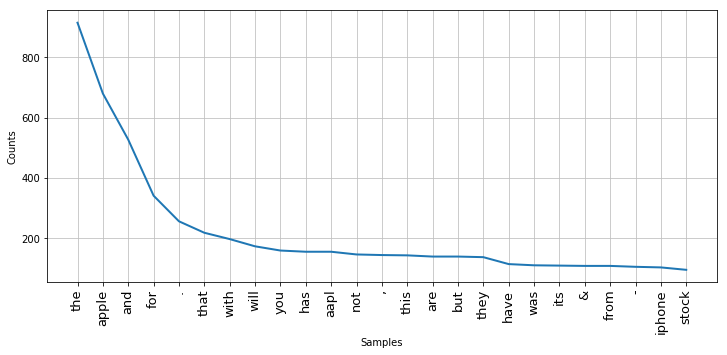

In [16]:
# most common words in twitter dataset
all_words = []
for line in list(dft.tweet):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

Stopwords are the English words which do not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc. Such words are already captured this in corpus named corpus.

Below we are going to list out those popular stopwords which are not contributing to finding the meaning of a sentence

In [17]:
import nltk
from nltk.corpus import stopwords
stopwords = stopwords.words('english')[0:20]
#listing out stop words which do not support our sentiment
stopwords_specific = [stopwords,'your','0','1012', 'and', 'for', 'the','.','that','with','you','has','was','from',"'",'&','this','are','their','its','.','']
stopwords_specific[10]

'you'

In [18]:
# Import stopwords with nltk.
from nltk.corpus import stopwords
stop = stopwords_specific

tweets = dft['tweet']

test = pd.DataFrame(tweets)
test.columns = ["tweet"]

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
dft['tweet'] = dft['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
print(test)

                                                 tweet
0    official ios adoption stats published apple th...
1    haha your not very informed ’ rip not based th...
2    with & star witness wants judge koh free billi...
3    would put most into apple, citigroup, boeing j...
4    for your information the trading symbol for co...
..                                                 ...
979                       think time say goodbye aapl.
980  apple inc. play long after this breakout till ...
981  . airpods will continue their dominance the mo...
982  apple facts won', and haven' the past, squashe...
983  from common sense, ’ guess:\n- tweeting “aapl ...

[984 rows x 1 columns]


Now our below graph is going to refelct a different trajectory given our removed stop words. Words like "buy, new, now, think" have more meaning to sentiment. 

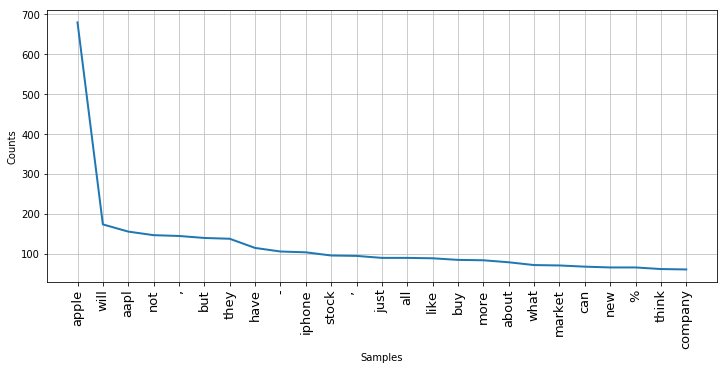

In [19]:
all_words = []
for line in list(dft.tweet):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

In [20]:
import string 
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [21]:
#check Jeffs slack for removing punctuation

### Sentiment Analysis

In [22]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      984 non-null    object
 1   tweet     984 non-null    object
 2   retweet   984 non-null    bool  
 3   nlikes    984 non-null    int64 
 4   nreplies  984 non-null    int64 
dtypes: bool(1), int64(2), object(2)
memory usage: 31.8+ KB


In [23]:
dft.shape

(984, 5)

### Subjectivity and Polarity

Subjectivity: Subjectivity in sentiment analysis refers to expression of opinions, evaluations, feelings, and speculations and thus incorporates sentiment.

Polarity: Polarity in sentiment analysis refers to identifying sentiment orientation (positive, neutral, and negative) in written or spoken language.

In [24]:
from textblob import TextBlob
from IPython.display import Markdown, display

In [25]:
#Create a function to get the subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

#Create a function to get the polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [26]:
#Create two new columns 
dft['Subjectivity'] = dft['tweet'].apply(getSubjectivity)
dft['Polarity'] = dft['tweet'].apply(getPolarity)

#Show new dataframe 
dft.head()

,date,tweet,retweet,nlikes,nreplies,Subjectivity,Polarity
0,2019-02-27 15:00:24,official ios adoption stats published apple th...,False,1,1,0.000000,0.000000
1,2019-02-27 08:55:56,haha not very informed ’ rip not based trend p...,False,1,1,0.170000,0.020000
2,2019-02-27 08:11:30,star witness wants judge koh free billion non-...,False,2,0,0.366667,0.069444
3,2019-02-26 20:05:09,"would put most into apple, citigroup, boeing j...",False,0,0,0.517857,0.392857
4,2019-02-26 13:36:15,information trading symbol company called cool...,False,0,0,0.650000,0.350000


# EDA

### WordCloud Visualization

We will first be doing some visualizations into the types of sentences both positive and negative we have

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


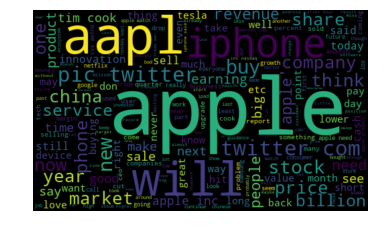

In [28]:
#Plot the worldcloud 
allwords = ' '.join([twts for twts in dft['tweet']])
wordCloud = WordCloud(width = 500, height = 300, random_state = 21, max_font_size = 119).generate(allwords)

plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

Some of the biggest words point to "will", "price", "phone", "buy", "now"

In [29]:
#Create a function to compute the negative, neutral and positive analysis

def getAnalysis(score):
    if score < 0: 
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    elif score > 0:
        return 'Positive'
    
dft['Analysis'] = dft['Polarity'].apply(getAnalysis)
dft

,date,tweet,retweet,nlikes,nreplies,Subjectivity,Polarity,Analysis
0,2019-02-27 15:00:24,official ios adoption stats published apple th...,False,1,1,0.000000,0.000000,Neutral
1,2019-02-27 08:55:56,haha not very informed ’ rip not based trend p...,False,1,1,0.170000,0.020000,Positive
2,2019-02-27 08:11:30,star witness wants judge koh free billion non-...,False,2,0,0.366667,0.069444,Positive
3,2019-02-26 20:05:09,"would put most into apple, citigroup, boeing j...",False,0,0,0.517857,0.392857,Positive
4,2019-02-26 13:36:15,information trading symbol company called cool...,False,0,0,0.650000,0.350000,Positive
...,...,...,...,...,...,...,...,...
979,2019-01-01 21:40:55,think time say goodbye aapl.,False,2,0,0.000000,0.000000,Neutral
980,2019-01-01 16:34:55,apple inc. play long after breakout till 163 s...,False,0,0,0.233333,-0.108333,Negative
981,2019-01-01 14:25:18,airpods will continue dominance most important...,False,511,18,0.505303,0.267424,Positive
982,2019-01-01 10:36:03,"apple facts won', haven' past, squashed doomed...",False,4,0,0.375000,-0.041667,Negative


In [30]:
#Print all the positive tweets
j=1
sortedDF = dft.sort_values(by=['Polarity'])
for i in range(0, sortedDF.shape[0]):
    if(sortedDF['Analysis'][i] == 'Positive'):
        print(str(j) + ') '+sortedDF['tweet'][i])
        print()
        j = j+1

1) haha not very informed ’ rip not based trend presented. revenue will rise off bottom chips, modems fueling chinese oems recent growth into global markets. isn’ customer anymore using inferior

2) star witness wants judge koh free billion non-americans paying royalties american innovation. suits huawei just fine don’ have china government stabbing them back! …

3) would put most into apple, citigroup, boeing johnson johnson stocks , right ?

4) information trading symbol company called cool technologies inc. sign used twitter front any stock trading name. example apple stock sharing name stock. http://cooltechnologiesinc.com

5) daily: peculiarly stopped dead tracks again right 175, when should have coasted 200ma after breakout like that. hunch added vbp... sure enough one massive vbp bar! facing lot resistance pic.twitter.com/xyjluvtfo8

6) saw show last night. great insight early clue new direction. the, again, been hammering topic: apple' gotta something. hoya saxa. brother adami 

In [31]:
#Print all the negative tweets
j=1
sortedDF = dft.sort_values(by=['Polarity'], ascending=False)
for i in range(0, sortedDF.shape[0]):
    if(sortedDF['Analysis'][i] == 'Negative'):
        print(str(j) + ') '+ sortedDF['tweet'][i])
        print()
        j = j+1

1) thoughts: -tired waiting mbp worth spending + -this would push needed make switch some other non apple device -short

2) s10 really put everything offer till date shame. apple better innovate something worth year rather than usual jumping processor usual display crap.

3) “for apple, would streamline app store potentially boost revenue syndicating apps all devices” , means could buy less devices. yay!

4) email received confirming transaction processed vide p23166782093 which did not trying connect apple but not able pls look into matter confirm same fake email been miss used.

5) ’ long term investment, don’ sell - aapl will hit (200 - 230) amzn (1900 - 2000) top 500 companies don’ down short time need wait least months

6) //2018 – watch steve jobs passionately defend his commitment apple 1997; //2018 – apple-samsung battle over smartphone patents revives 2011 fight; //2018 – apple’ worldwide developers conference kicks off june san jose; //2018 –

7) //2018 – black lawmakers will

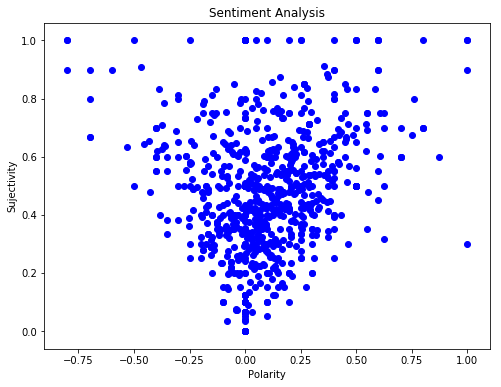

In [32]:
#plot the polarity and subjectivity
plt.figure(figsize=(8,6))
for i in range(0, dft.shape[0]):
    plt.scatter(dft['Polarity'][i], dft['Subjectivity'][i], color= 'Blue')
    
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Sujectivity')
plt.show()
    

Positive    511
Neutral     248
Negative    225
Name: Analysis, dtype: int64

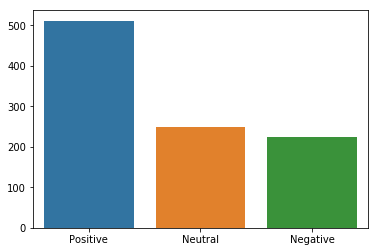

In [33]:
import seaborn as sns
#Bar graph to visualize sentiment

y = dft["Analysis"].value_counts()
sns.barplot(y.index, y.values)
y

Predominately positive correlation of tweets

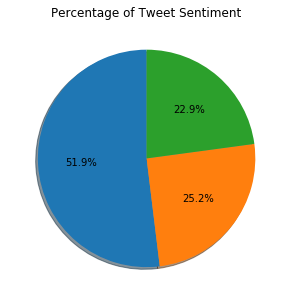

In [34]:
from pylab import rcParams

#Pie Chart shows a better visualization

sizes = dft['Analysis'].value_counts(sort = True)
colors = ["blue","orange"] 
rcParams['figure.figsize'] = 5,5
# Plot
plt.pie(sizes, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Percentage of Tweet Sentiment')
plt.show()

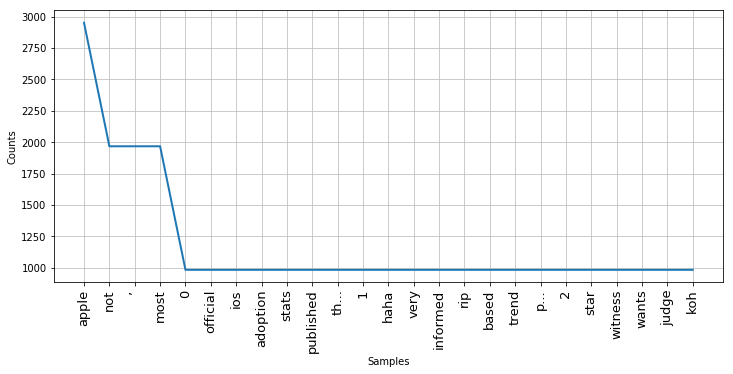

In [35]:
# Join all the tweets into a single string
all_words_string = ' '.join([str(dft.tweet) for tweet in dft.tweet])

# Make a list of all the words in the dataframe
all_words_list = all_words_string.split()

# Plot word frequency distribution of first few words

plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
freq_dist = nltk.FreqDist(all_words_list)
freq_dist.plot(25,cumulative=False)

Breaking it down by total number of most popular words

In [37]:
word_freq = nltk.FreqDist(all_words_list)
freq_df = pd.DataFrame({'Word': list(word_freq.keys()), 'Count': list(word_freq.values())}).sort_values(by=['Count'], ascending=False)
freq_df.head(15)

,Word,Count
6,apple,2952
13,’,1968
30,most,1968
10,not,1968
0,0,984
63,dominance,984
62,continue,984
61,will,984
60,airpods,984
59,981,984


### Combine Datasets

Now that we have our two datasets finalized, its time to combine them in preparation for our time series. We will do so with an inner join

In [38]:
#Average subjectivity and polarity scores based on day rather than time
dft1 = dft[['date','Subjectivity','Polarity','Analysis']]
dft1.head()

,date,Subjectivity,Polarity,Analysis
0,2019-02-27 15:00:24,0.000000,0.000000,Neutral
1,2019-02-27 08:55:56,0.170000,0.020000,Positive
2,2019-02-27 08:11:30,0.366667,0.069444,Positive
3,2019-02-26 20:05:09,0.517857,0.392857,Positive
4,2019-02-26 13:36:15,0.650000,0.350000,Positive


In [39]:
dft1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          984 non-null    object 
 1   Subjectivity  984 non-null    float64
 2   Polarity      984 non-null    float64
 3   Analysis      984 non-null    object 
dtypes: float64(2), object(2)
memory usage: 30.9+ KB


In [40]:
dft1.date = pd.to_datetime(dft1.date)

In [41]:
#Average subjectivity and polarity scores based on day rather than time. Remove time. 
dft1 = dft1.resample('D', on='date').mean()
dft1.head()

,Subjectivity,Polarity
date,,
2019-01-01,0.366809,0.165720
2019-01-02,0.401569,0.072436
2019-01-03,0.417538,0.073869
2019-01-04,0.446498,0.068860
2019-01-05,0.477065,0.239604


In [42]:
dfs.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,154.889999,158.850006,154.229996,157.919998,154.516388,37039700
2019-01-03,143.979996,145.720001,142.000000,142.190002,139.125412,91312200
2019-01-04,144.529999,148.550003,143.800003,148.259995,145.064575,58607100
2019-01-07,148.699997,148.830002,145.899994,147.929993,144.741714,54777800
2019-01-08,149.559998,151.820007,148.520004,150.750000,147.500916,41025300


Creating a new column below which identifies Open_Close Shift. The pupose of this is to more concretely see where the stock price went from start to end of the day. This gives us a eaiser visual into its comparision with polarity and subjectivity 

In [43]:
# Create column to view the change in open prices from prior days close
# Create a column that labels whether the open-close difference was positive or negative

dfs['Open_Close_Shift'] = dfs.Close - dfs.Open
dfs['Positive_Negative'] = dfs['Positive_Negative'] = dfs.Open_Close_Shift.apply(lambda x: 1 if (x > 0) else (-1 if x < 0 else 0))
dfs.head()

,Open,High,Low,Close,Adj Close,Volume,Open_Close_Shift,Positive_Negative
Date,,,,,,,,
2019-01-02,154.889999,158.850006,154.229996,157.919998,154.516388,37039700,3.029999,1
2019-01-03,143.979996,145.720001,142.000000,142.190002,139.125412,91312200,-1.789993,-1
2019-01-04,144.529999,148.550003,143.800003,148.259995,145.064575,58607100,3.729996,1
2019-01-07,148.699997,148.830002,145.899994,147.929993,144.741714,54777800,-0.770004,-1
2019-01-08,149.559998,151.820007,148.520004,150.750000,147.500916,41025300,1.190002,1


In [44]:
df = pd.merge(dfs, dft1, how='inner', left_index=True, right_index=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Open_Close_Shift,Positive_Negative,Subjectivity,Polarity
2019-01-02,154.889999,158.850006,154.229996,157.919998,154.516388,37039700,3.029999,1,0.401569,0.072436
2019-01-03,143.979996,145.720001,142.000000,142.190002,139.125412,91312200,-1.789993,-1,0.417538,0.073869
2019-01-04,144.529999,148.550003,143.800003,148.259995,145.064575,58607100,3.729996,1,0.446498,0.068860
2019-01-07,148.699997,148.830002,145.899994,147.929993,144.741714,54777800,-0.770004,-1,0.356555,0.077573
2019-01-08,149.559998,151.820007,148.520004,150.750000,147.500916,41025300,1.190002,1,0.446780,0.130949


In [45]:
#adding Analysis back into the dataframe
df['Analysis'] = df['Polarity'].apply(getAnalysis)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Open_Close_Shift,Positive_Negative,Subjectivity,Polarity,Analysis
2019-01-02,154.889999,158.850006,154.229996,157.919998,154.516388,37039700,3.029999,1,0.401569,0.072436,Positive
2019-01-03,143.979996,145.720001,142.000000,142.190002,139.125412,91312200,-1.789993,-1,0.417538,0.073869,Positive
2019-01-04,144.529999,148.550003,143.800003,148.259995,145.064575,58607100,3.729996,1,0.446498,0.068860,Positive
2019-01-07,148.699997,148.830002,145.899994,147.929993,144.741714,54777800,-0.770004,-1,0.356555,0.077573,Positive
2019-01-08,149.559998,151.820007,148.520004,150.750000,147.500916,41025300,1.190002,1,0.446780,0.130949,Positive


In [46]:
df.index.names = ['Date']
df.head()

,Open,High,Low,Close,Adj Close,Volume,Open_Close_Shift,Positive_Negative,Subjectivity,Polarity,Analysis
Date,,,,,,,,,,,
2019-01-02,154.889999,158.850006,154.229996,157.919998,154.516388,37039700,3.029999,1,0.401569,0.072436,Positive
2019-01-03,143.979996,145.720001,142.000000,142.190002,139.125412,91312200,-1.789993,-1,0.417538,0.073869,Positive
2019-01-04,144.529999,148.550003,143.800003,148.259995,145.064575,58607100,3.729996,1,0.446498,0.068860,Positive
2019-01-07,148.699997,148.830002,145.899994,147.929993,144.741714,54777800,-0.770004,-1,0.356555,0.077573,Positive
2019-01-08,149.559998,151.820007,148.520004,150.750000,147.500916,41025300,1.190002,1,0.446780,0.130949,Positive


In [47]:
#drop unneccary columns
df.drop(['Open','High','Low','Close','Adj Close','Volume'], axis=1, inplace=True)
df.head()

,Open_Close_Shift,Positive_Negative,Subjectivity,Polarity,Analysis
Date,,,,,
2019-01-02,3.029999,1,0.401569,0.072436,Positive
2019-01-03,-1.789993,-1,0.417538,0.073869,Positive
2019-01-04,3.729996,1,0.446498,0.068860,Positive
2019-01-07,-0.770004,-1,0.356555,0.077573,Positive
2019-01-08,1.190002,1,0.446780,0.130949,Positive


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39 entries, 2019-01-02 to 2019-02-27
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open_Close_Shift   39 non-null     float64
 1   Positive_Negative  39 non-null     int64  
 2   Subjectivity       39 non-null     float64
 3   Polarity           39 non-null     float64
 4   Analysis           39 non-null     object 
dtypes: float64(3), int64(1), object(1)
memory usage: 1.8+ KB


In [49]:
df.head()

,Open_Close_Shift,Positive_Negative,Subjectivity,Polarity,Analysis
Date,,,,,
2019-01-02,3.029999,1,0.401569,0.072436,Positive
2019-01-03,-1.789993,-1,0.417538,0.073869,Positive
2019-01-04,3.729996,1,0.446498,0.068860,Positive
2019-01-07,-0.770004,-1,0.356555,0.077573,Positive
2019-01-08,1.190002,1,0.446780,0.130949,Positive


Visualization to show that negative tweets were the only places where we saw a negative analysis. This is a good sign for our model and correlation

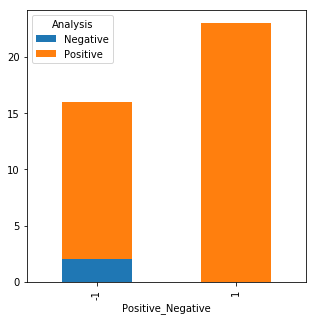

In [50]:
#Taking a look a visual look at sentiment and change in stock price
df.groupby(["Positive_Negative", "Analysis"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5))


### Line Graphs of our columns

Showing quick line graphs for each of our columns

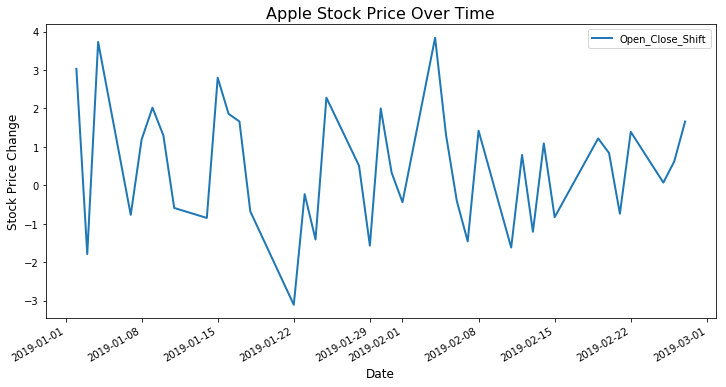

In [51]:
#open_close_shift
df['Open_Close_Shift'].plot(figsize=(12,6), linewidth=2, fontsize=10)
plt.legend(ncol=2)
plt.xlabel("Date",fontsize=12)
plt.ylabel("Stock Price Change",fontsize=12)
plt.title("Apple Stock Price Over Time", fontsize=16);


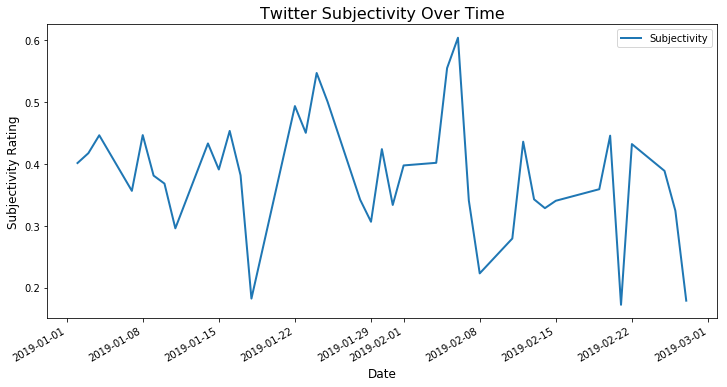

In [52]:
#Subjectivity 
df['Subjectivity'].plot(figsize=(12,6), linewidth=2, fontsize=10)
plt.legend(ncol=2)
plt.xlabel("Date",fontsize=12)
plt.ylabel("Subjectivity Rating",fontsize=12)
plt.title("Twitter Subjectivity Over Time", fontsize=16);

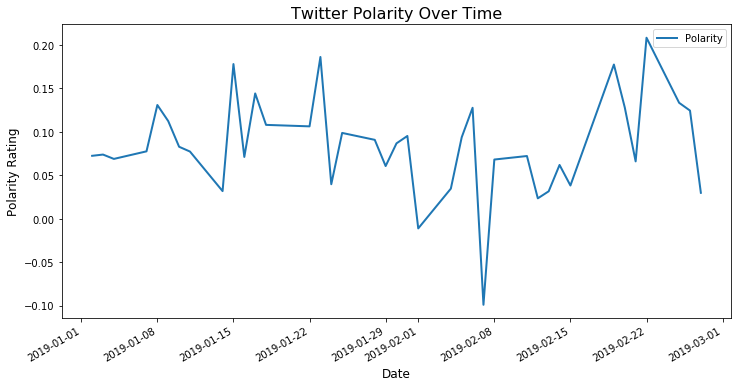

In [53]:
#Polarity
df['Polarity'].plot(figsize=(12,6), linewidth=2, fontsize=10)
plt.legend(ncol=2)
plt.xlabel("Date",fontsize=12)
plt.ylabel("Polarity Rating",fontsize=12)
plt.title("Twitter Polarity Over Time", fontsize=16);

In [54]:
df1 = df.copy()
df1["Open_Close_Shift"]=((df1["Open_Close_Shift"]-df1["Open_Close_Shift"].min())/(df1["Open_Close_Shift"].max()-df1["Open_Close_Shift"].min()))*.6
df1["Polarity"]=((df1["Polarity"]-df1["Polarity"].min())/(df1["Polarity"].max()-df1["Polarity"].min()))*.6

In [55]:
df1.drop(['Positive_Negative','Analysis','Subjectivity'], axis=1, inplace=True)

In [56]:
df1.to_csv('stocks-polarity.csv',index=True)

Below we will explore the trajectory of Polarity vs Subjectivity in predicting stock price. Which one follows a more silmilar pattern

            Open_Close_Shift  Polarity
Date                                  
2019-01-02          0.530072  0.334717
2019-01-03          0.113958  0.337513
2019-01-04          0.590504  0.327742
2019-01-07          0.202014  0.344739
2019-01-08          0.371223  0.448857


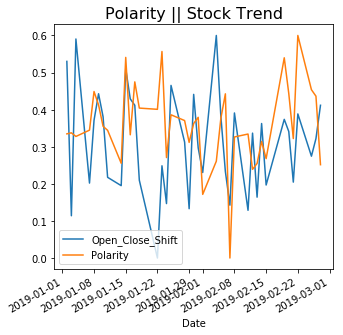

<function matplotlib.pyplot.legend(*args, **kwargs)>

In [57]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')
series = read_csv('stocks-polarity.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# summarize first few rows
print(series.head())
# line plot
series.plot()
plt.title("Polarity || Stock Trend", fontsize=16);
pyplot.show()
plt.legend


In [58]:
df2=df.copy()
df2["Open_Close_Shift"]=((df2["Open_Close_Shift"]-df2["Open_Close_Shift"].min())/(df2["Open_Close_Shift"].max()-df2["Open_Close_Shift"].min()))*.6
df2["Subjectivity"]=((df2["Subjectivity"]-df2["Subjectivity"].min())/(df2["Subjectivity"].max()-df2["Subjectivity"].min()))*.6

In [59]:
df2.drop(['Polarity','Positive_Negative','Analysis'], axis=1, inplace=True)

In [60]:
df2.to_csv('stocks-subjectivity.csv',index=True)

            Open_Close_Shift  Subjectivity
Date                                      
2019-01-02          0.530072      0.318476
2019-01-03          0.113958      0.340652
2019-01-04          0.590504      0.380866
2019-01-07          0.202014      0.255968
2019-01-08          0.371223      0.381258


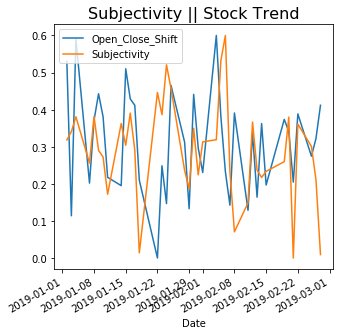

<function matplotlib.pyplot.legend(*args, **kwargs)>

In [61]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')
series = read_csv('stocks-subjectivity.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# summarize first few rows
print(series.head())
# line plot
series.plot()
plt.title("Subjectivity || Stock Trend", fontsize=16);
pyplot.show()
plt.legend

Ultimately it is visually clear that Subjectivity more closely follows the curve of stock price than Polarity. We will use Subjectiviity as our predictive columnd alongside change in stock price below

# Time Series Pediction Model

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense,SimpleRNN,LSTM
from keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib as mpl
import os

Using TensorFlow backend.


In [63]:
df.drop(['Positive_Negative','Analysis','Polarity'], axis=1, inplace=True)

In [64]:
df.head()

,Open_Close_Shift,Subjectivity
Date,,
2019-01-02,3.029999,0.401569
2019-01-03,-1.789993,0.417538
2019-01-04,3.729996,0.446498
2019-01-07,-0.770004,0.356555
2019-01-08,1.190002,0.446780


In [65]:
df.shape

(39, 2)

We are going to use a multivariate time series model to account for both subjectivity and stock price. Allows us to use two inputs and spit out 1 output (predicted stock price). 


In [66]:
# multivariate data preparation
from numpy import array
from numpy import hstack

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence
in_seq1 = array(df['Subjectivity'])
in_seq2 = array(df['Open_Close_Shift'])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
print(X.shape, y.shape)
# summarize the data
for i in range(len(X)):
    print(X[i], y[i])
# multivariate data preparation
from numpy import array
from numpy import hstack
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
 

(37, 3, 2) (37,)
[[ 0.40156908  3.02999878]
 [ 0.41753849 -1.78999329]
 [ 0.44649833  3.72999573]] 4.176494060995729
[[ 0.41753849 -1.78999329]
 [ 0.44649833  3.72999573]
 [ 0.35655452 -0.77000427]] -0.4134497567152453
[[ 0.44649833  3.72999573]
 [ 0.35655452 -0.77000427]
 [ 0.44678041  1.19000244]] 1.6367828518027319
[[ 0.35655452 -0.77000427]
 [ 0.44678041  1.19000244]
 [ 0.38124551  2.02000427]] 2.401249785628326
[[0.44678041 1.19000244]
 [0.38124551 2.02000427]
 [0.36828704 1.30000305]] 1.6682900887948495
[[ 0.38124551  2.02000427]
 [ 0.36828704  1.30000305]
 [ 0.29594156 -0.5900116 ]] -0.29407003823812905
[[ 0.36828704  1.30000305]
 [ 0.29594156 -0.5900116 ]
 [ 0.43328373 -0.8500061 ]] -0.4167223733568948
[[ 0.29594156 -0.5900116 ]
 [ 0.43328373 -0.8500061 ]
 [ 0.39113636  2.80000305]] 3.191139415394176
[[ 0.43328373 -0.8500061 ]
 [ 0.39113636  2.80000305]
 [ 0.45354663  1.86000061]] 2.3135472373356896
[[0.39113636 2.80000305]
 [0.45354663 1.86000061]
 [0.38173163 1.66000366]] 2.0

Running the sample above first prints the shape of the X and y components. We can see that the X component has a three-dimensional structure.

The first dimension is the number of samples, in this case 37. The second dimension is the number of time steps per sample, in this case 3, the value specified to the function. Finally, the last dimension specifies the number of parallel time series or the number of variables, in this case 2 for the two parallel series.

We can then see that the input and output for each sample is printed, showing the three time steps for each of the two input series and the associated output for each sample.

In [67]:
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
 
# define input sequence
in_seq1 = array(df['Subjectivity'])
in_seq2 = array(df['Open_Close_Shift'])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(25, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)
# demonstrate prediction
x_input = array([[.39, .069], [.32, .61], [.17, 1.6]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[1.7539388]]


When making a prediction, the model expects three time steps for two input time series.

We can predict the next value in the output series proving the input values of subjectivity and stock price for the past 3 days



In [68]:
X.shape

(37, 3, 2)

In [69]:
X[-1].reshape(1,3,2)

array([[[0.38888889, 0.06999207],
        [0.32441743, 0.61999512],
        [0.17888889, 1.6599884 ]]])

In [70]:
x_input = array([[.2, .1], [-.4, -.3], [.1, -1]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[-0.4810477]]


Running the past three inputs above, fits the model, and makes a prediction.


Now lets create a train and test set check out model

In [71]:
train_x = X[:30]

train_y = y[:30]

test_x = X[30:]

test_y = y[30:]

In [72]:
model_history = model.fit(train_x, train_y, epochs=200, verbose=1,validation_data=[test_x,test_y])
model_history
#loss ie MSE. Good that is getting smaller overtime 

Train on 30 samples, validate on 7 samples
Epoch 1/200
30/30 [==============================] - 0s 5ms/step - loss: 0.0362 - val_loss: 0.0460
Epoch 2/200
30/30 [==============================] - 0s 292us/step - loss: 0.0360 - val_loss: 0.0454
Epoch 3/200
30/30 [==============================] - 0s 276us/step - loss: 0.0358 - val_loss: 0.0448
Epoch 4/200
30/30 [==============================] - 0s 276us/step - loss: 0.0357 - val_loss: 0.0443
Epoch 5/200
30/30 [==============================] - 0s 256us/step - loss: 0.0356 - val_loss: 0.0439
Epoch 6/200
30/30 [==============================] - 0s 372us/step - loss: 0.0355 - val_loss: 0.0435
Epoch 7/200
30/30 [==============================] - 0s 484us/step - loss: 0.0354 - val_loss: 0.0433
Epoch 8/200
30/30 [==============================] - 0s 790us/step - loss: 0.0353 - val_loss: 0.0431
Epoch 9/200
30/30 [==============================] - 0s 242us/step - loss: 0.0352 - val_loss: 0.0429
Epoch 10/200
30/30 [==============================

30/30 [==============================] - 0s 373us/step - loss: 0.0266 - val_loss: 0.0371
Epoch 82/200
30/30 [==============================] - 0s 363us/step - loss: 0.0265 - val_loss: 0.0370
Epoch 83/200
30/30 [==============================] - 0s 291us/step - loss: 0.0264 - val_loss: 0.0369
Epoch 84/200
30/30 [==============================] - 0s 405us/step - loss: 0.0263 - val_loss: 0.0368
Epoch 85/200
30/30 [==============================] - 0s 432us/step - loss: 0.0262 - val_loss: 0.0367
Epoch 86/200
30/30 [==============================] - 0s 535us/step - loss: 0.0261 - val_loss: 0.0366
Epoch 87/200
30/30 [==============================] - 0s 253us/step - loss: 0.0260 - val_loss: 0.0365
Epoch 88/200
30/30 [==============================] - 0s 295us/step - loss: 0.0259 - val_loss: 0.0364
Epoch 89/200
30/30 [==============================] - 0s 365us/step - loss: 0.0258 - val_loss: 0.0363
Epoch 90/200
30/30 [==============================] - 0s 372us/step - loss: 0.0258 - val_loss: 

Epoch 161/200
30/30 [==============================] - 0s 302us/step - loss: 0.0201 - val_loss: 0.0299
Epoch 162/200
30/30 [==============================] - 0s 340us/step - loss: 0.0200 - val_loss: 0.0299
Epoch 163/200
30/30 [==============================] - 0s 297us/step - loss: 0.0199 - val_loss: 0.0298
Epoch 164/200
30/30 [==============================] - 0s 357us/step - loss: 0.0199 - val_loss: 0.0297
Epoch 165/200
30/30 [==============================] - 0s 417us/step - loss: 0.0198 - val_loss: 0.0296
Epoch 166/200
30/30 [==============================] - 0s 414us/step - loss: 0.0197 - val_loss: 0.0295
Epoch 167/200
30/30 [==============================] - 0s 551us/step - loss: 0.0197 - val_loss: 0.0294
Epoch 168/200
30/30 [==============================] - 0s 371us/step - loss: 0.0196 - val_loss: 0.0293
Epoch 169/200
30/30 [==============================] - 0s 288us/step - loss: 0.0195 - val_loss: 0.0292
Epoch 170/200
30/30 [==============================] - 0s 371us/step - lo

Our loss and val_loss (MSE) is decreasing as our Epochs move forward. This is a good sign that our model is accurate.

In [73]:
model.predict(X[-1].reshape(1,3,2))

array([[1.8605964]], dtype=float32)

Our final product will be an input structure where we can plot in the past 3 days of inputs and it will spit our a predicted stock price

In [74]:
yesterday_stock = float(input("stock price change from yesterday = "))
yesterday_subjectivity = float(input("subjectivity  from yesterday = "))
two_days_ago_stock = float(input("stock price change from 2 days ago = "))
two_days_ago_subjectivity = float(input("subjectivity  from 2 days ago = "))
three_days_ago_stock = float(input("stock price change from 3 days ago = "))
three_days_ago_subjectivity = float(input("subjectivity  from 3 days ago = "))

x_input = array([[yesterday_stock,yesterday_subjectivity],[two_days_ago_stock, two_days_ago_subjectivity],
                [three_days_ago_stock, three_days_ago_subjectivity]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

stock price change from yesterday = .2
subjectivity  from yesterday = .3
stock price change from 2 days ago = 1
subjectivity  from 2 days ago = .4
stock price change from 3 days ago = 4
subjectivity  from 3 days ago = .2
[[1.3773104]]


# Conclusions

There is a correlation between tweet subjectivity and stock price. Some places I would further examine: 

1) Recurring twitter patterns. Would be great to tap into the Twitter API and pull a model that updates with daily tweets

2) Would be keen to run this model on other companies and see what the patterns look like

3) Intertwine other factors into predicting stock price such as newspaper headlines or specific company data 

